# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from sklearn import preprocessing
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

2023-12-03 18:37:47.877551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing

In [3]:
# Indexing with dates and forward filling for the missing dates , becuase the stock values doesnot change on the holidays.
# Min Max Sclaing - To make sure the data is all normalized
def preprocess(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df=df.sort_values(by="Date",ascending=True)
    df.set_index("Date",inplace=True)
    start_date = df.index.min()
    end_date = df.index.max()
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    missing_dates = all_dates.difference(df.index)
    print("The count of missing dates are: ",len(missing_dates))
    df = df.reindex(all_dates)
    df.ffill(inplace=True)
    x = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    n_df = pd.DataFrame(x_scaled,columns=df.columns)
    n_df.index = all_dates
    return df,n_df

In [4]:
df_g , n_df_g = preprocess('/Users/yashashvini/Desktop/MSU/CSE881/project/GOOGL.csv')
df_g.head()

The count of missing dates are:  1011


,Open,High,Low,Close,Adj Close,Volume
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000.0
2015-01-03,26.629999,26.790001,26.393999,26.477501,26.477501,26480000.0
2015-01-04,26.629999,26.790001,26.393999,26.477501,26.477501,26480000.0
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000.0
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000.0


In [5]:
# check for null values
df_g.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Visualizations

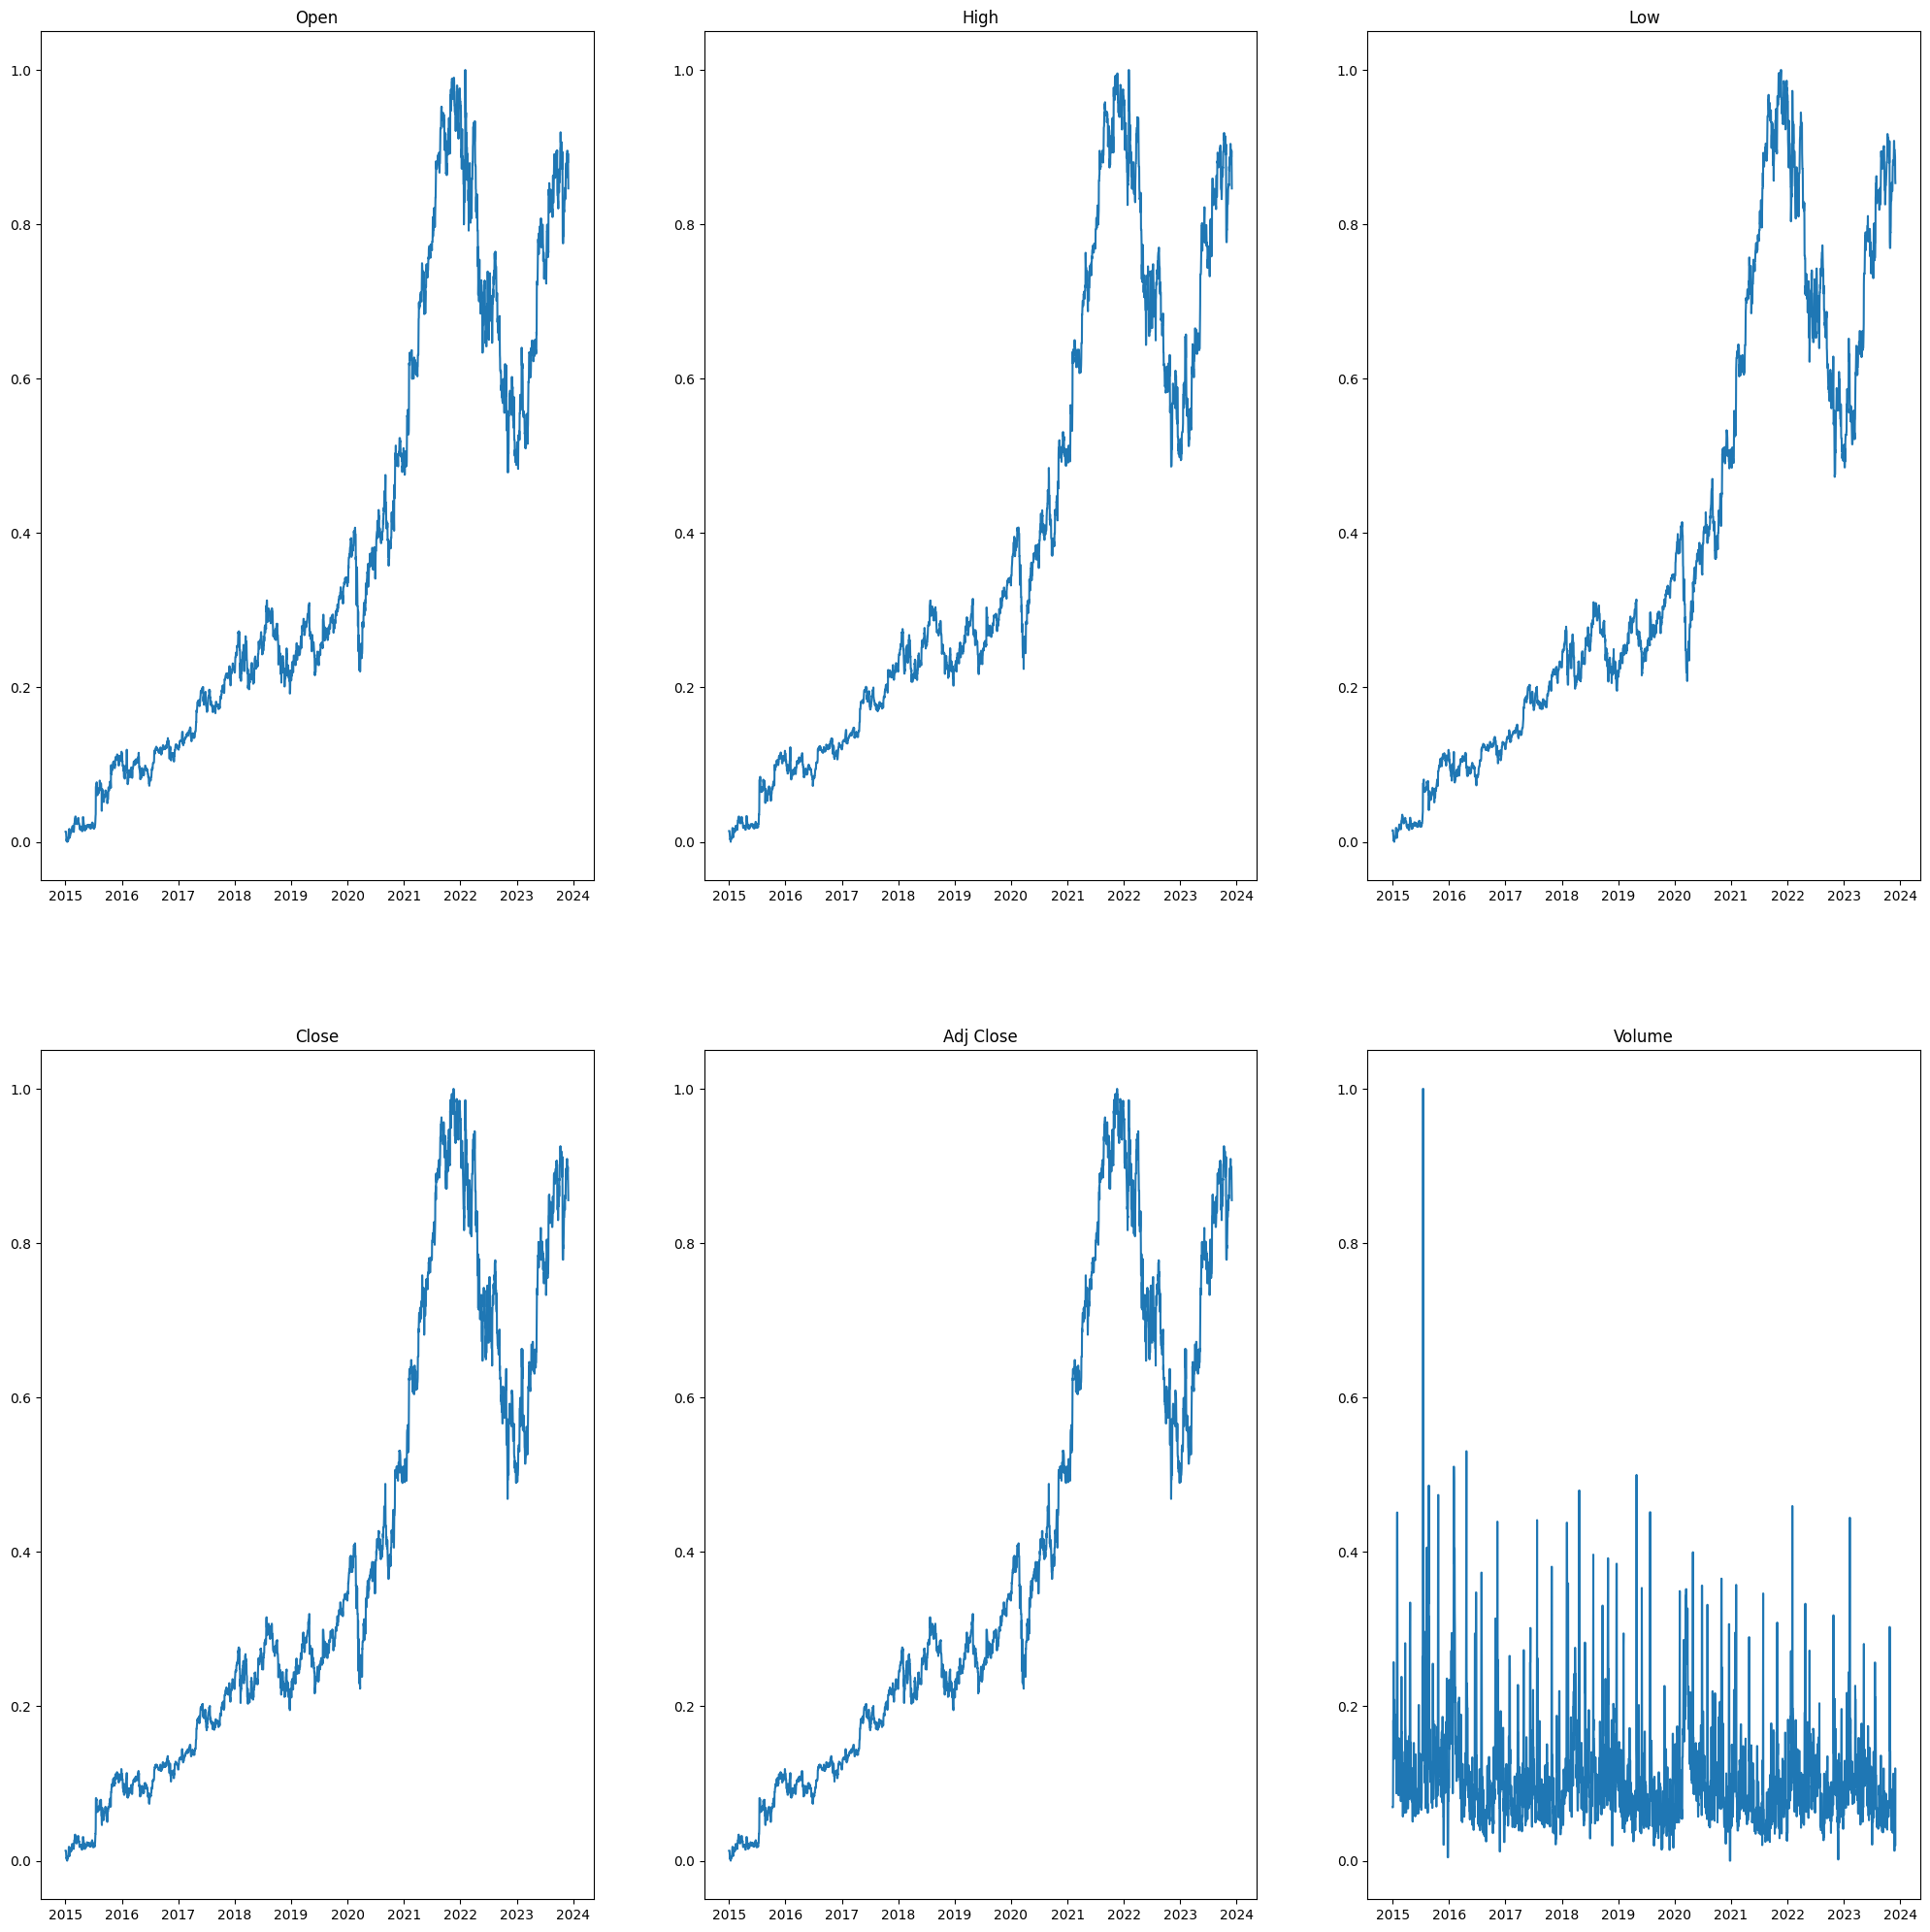

In [9]:
# Line plots of all the attributes, where the close, high, low, Adj Close, open shares teh same trend, becuase the stocks goes either 
# up or down, where as the volume talks about the number of stoeck shared in a day, which changes are different from the rest.
fig = plt.figure(figsize=(25,25))
i=1
for x in n_df_g.columns :
    plt.subplot(2,3,i)
    ax=sns.lineplot(n_df_g[x])
    ax.set(xlabel=None)
    plt.title(str(x), loc='center')
    plt.xlabel(None)
    plt.ylabel(None)
    i+=1
plt.show()

In [11]:
n_df_g.corr()   # We could see all the attributes other volume are highly correlated to each other.

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999768,0.999741,0.999441,0.999441,-0.182469
High,0.999768,1.000000,0.999703,0.999745,0.999745,-0.177620
Low,0.999741,0.999703,1.000000,0.999766,0.999766,-0.189486
Close,0.999441,0.999745,0.999766,1.000000,1.000000,-0.184634
Adj Close,0.999441,0.999745,0.999766,1.000000,1.000000,-0.184634
Volume,-0.182469,-0.177620,-0.189486,-0.184634,-0.184634,1.000000


<AxesSubplot: >

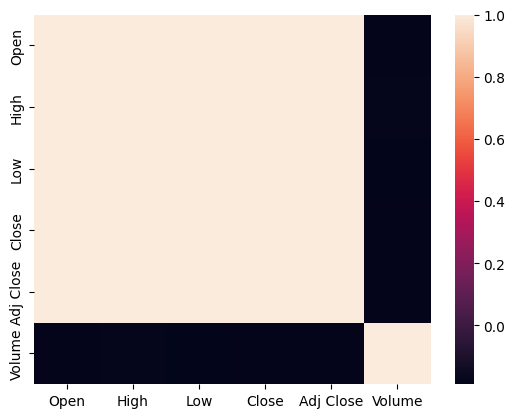

In [12]:
sns.heatmap(n_df_g.corr())   # By looking at the heat map we could say all the attributes are highly correlated that's the reason
                           # You could see the single shade, coz of the value is almost the same i.e 0.99

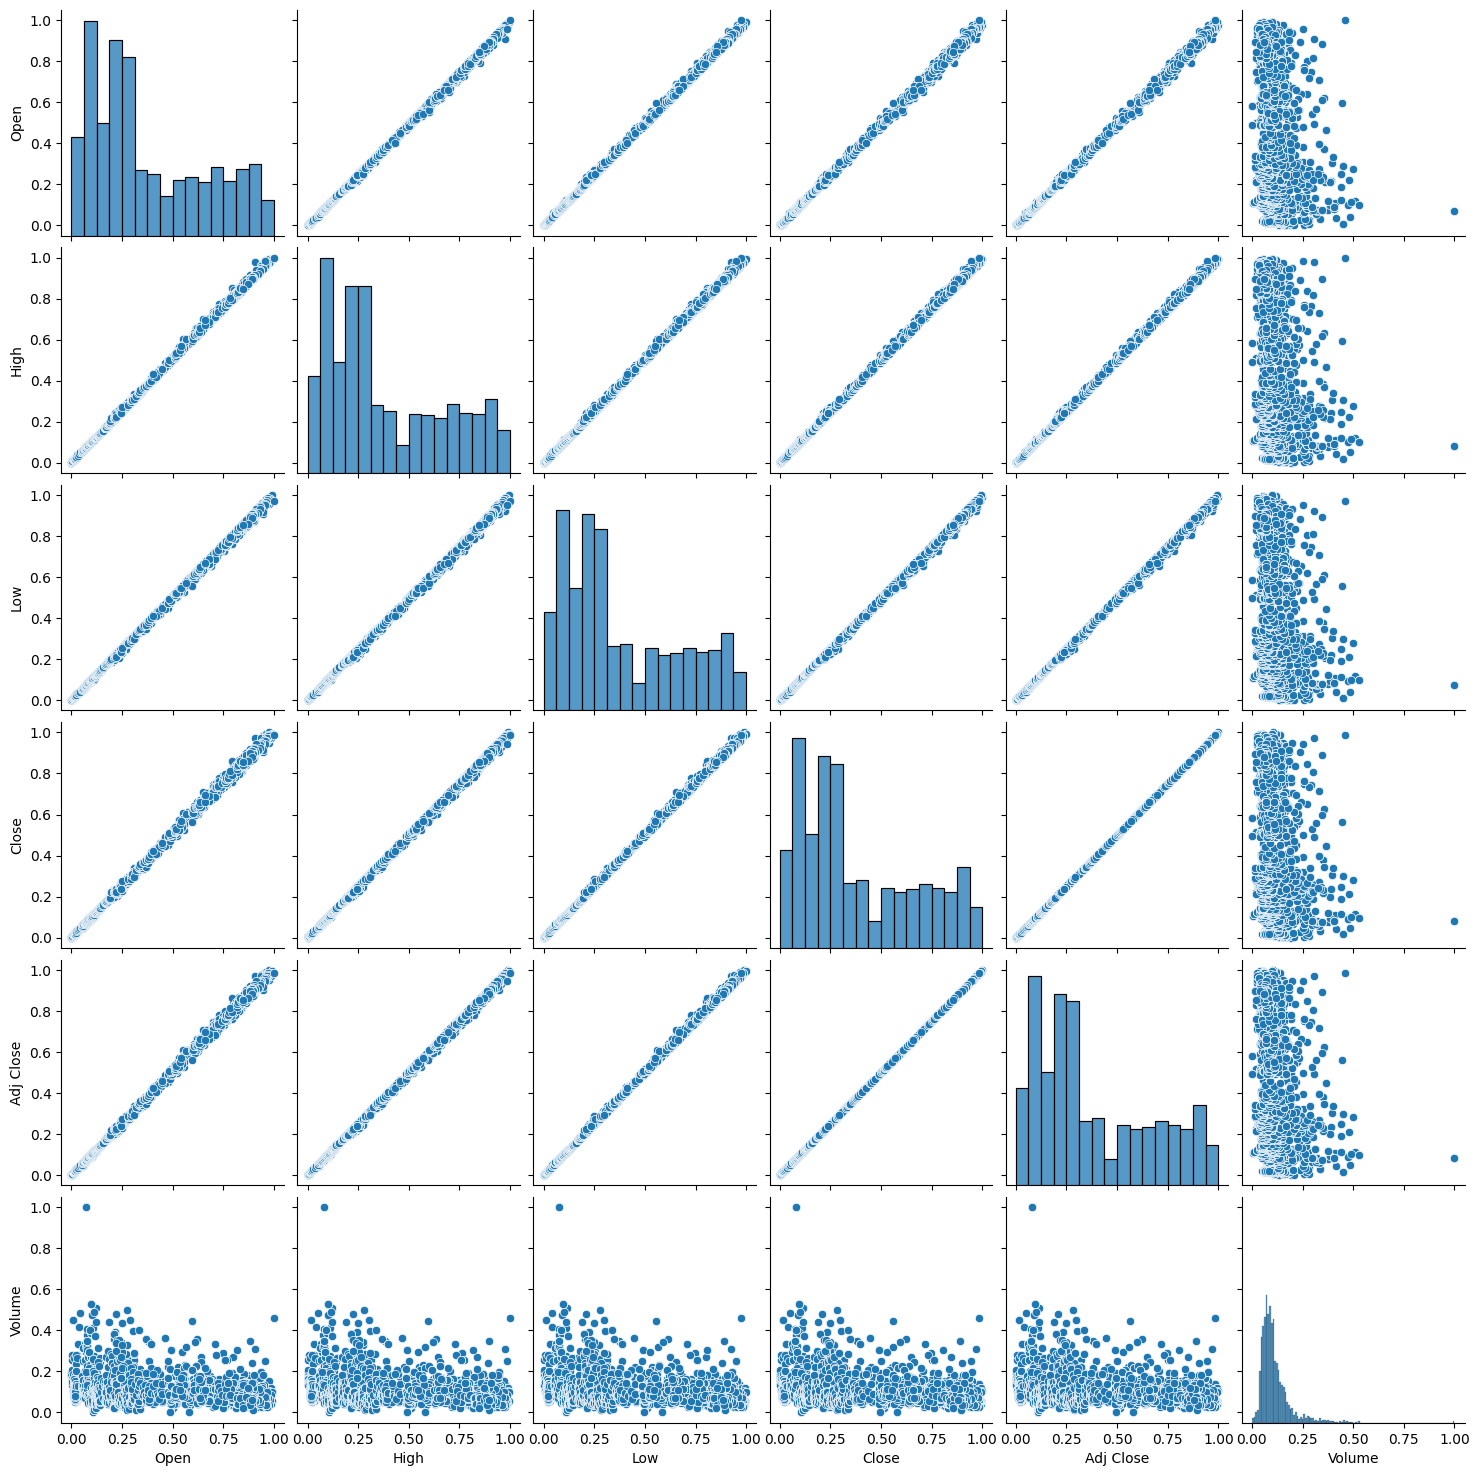

In [13]:
# Pair Plot  
sns.pairplot(n_df_g)
plt.show()
# This says that all the attributes are highly correlated expect volume, you can also see the trend is going up, which says its a 
# positive correlation, but the volume, is irregular, coz the value changes.

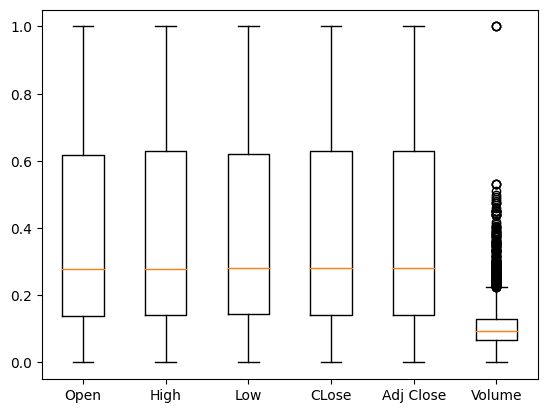

In [14]:
# Box plot, where you could see no outliers in all the attributes other than Volume
plt.boxplot(n_df_g)
plt.xticks([1,2,3,4,5,6],['Open', 'High', 'Low','CLose','Adj Close','Volume'])
plt.show()

In [10]:
# Candle Plots
# Used in finding the price movemenet i.e trend and it also helps to indtenify the value at the each point, since its interactive.[candle wick helps]
fig = go.Figure(data=[go.Candlestick(x=n_df_g.index,open=n_df_g['Open'], high=n_df_g['High'],low=n_df_g['Low'], close=n_df_g['Close'])])
fig.update_layout(title='Interactive Candlestick Chart', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=True)
fig.show()

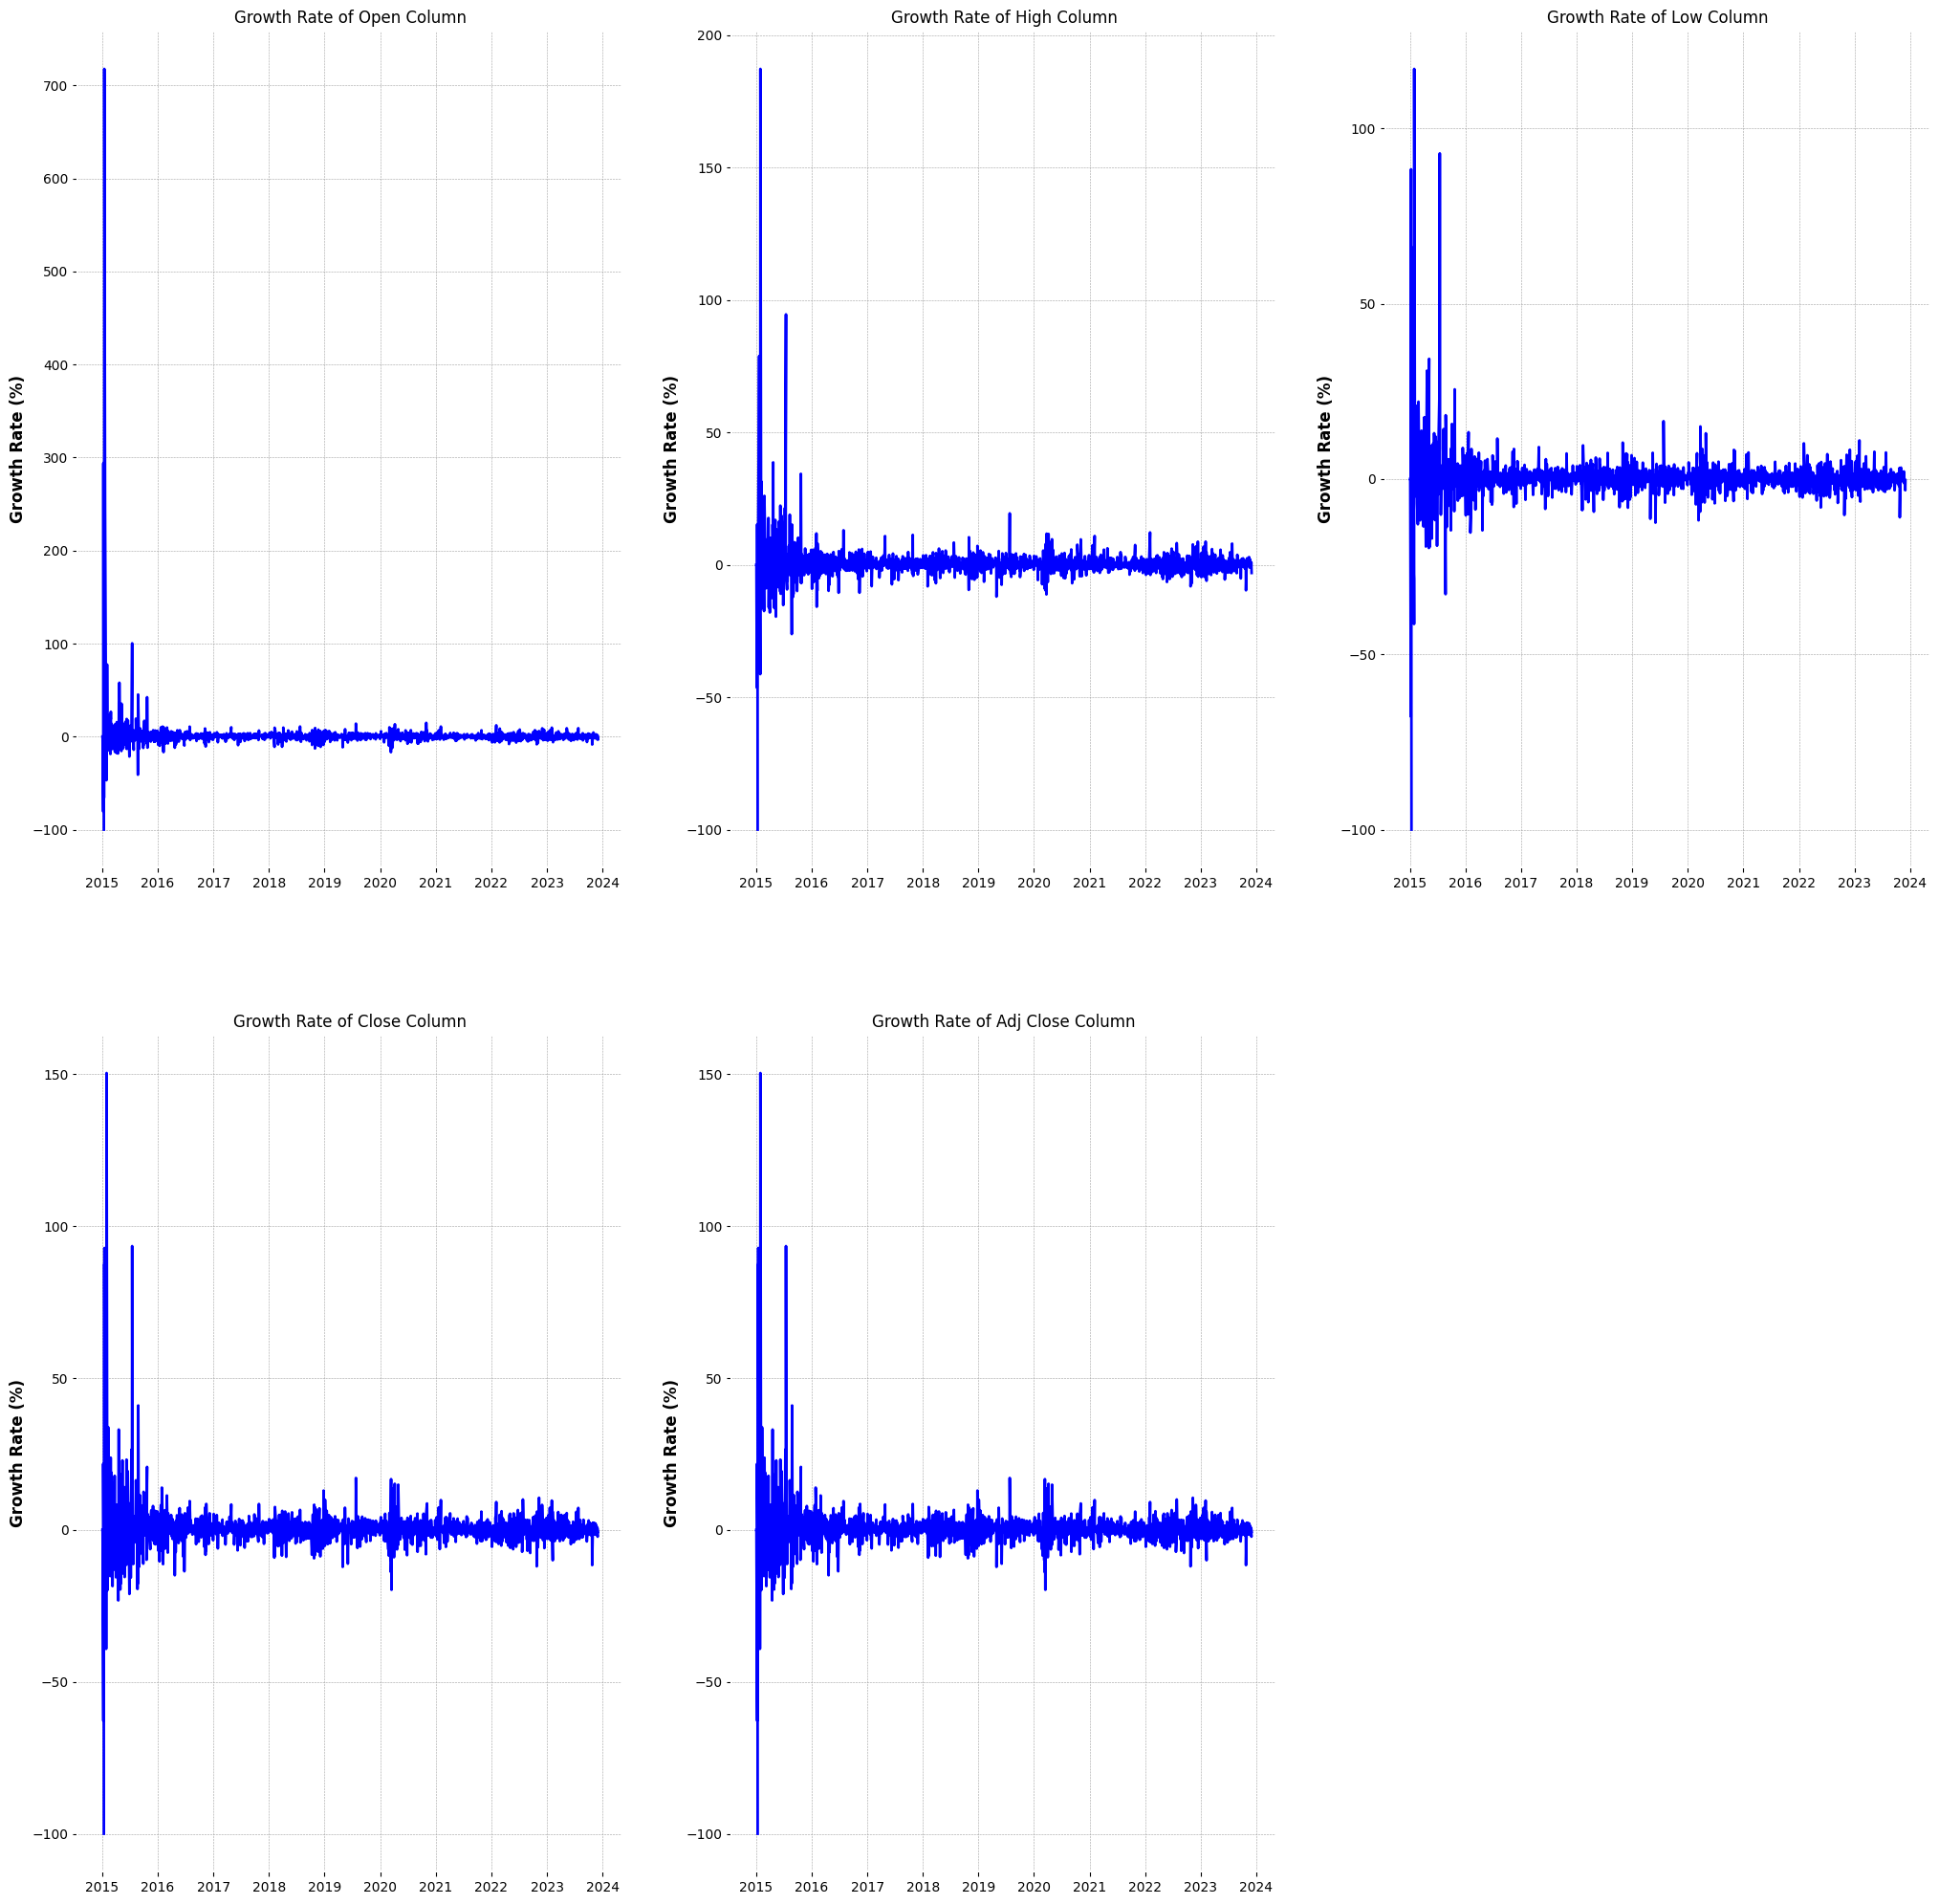

In [22]:
# Growth Plot  
# A consistently positive growth rate indicates an uptrend, whereas a consistently negative growth rate suggests a downtrend.
plt.figure(figsize=(25,25))
i=1
for x in n_df_g.columns[:-1]:
    plt.subplot(2,3,i)
    n_df_g['Growth Rate'] = (n_df_g[x] - n_df_g[x].shift(1)) / n_df_g[x].shift(1) * 100
    plt.plot(n_df_g.index, n_df_g['Growth Rate'], linestyle='-', color='b')
    plt.xlabel(None)
    plt.ylabel('Growth Rate (%)')
    plt.title(f'Growth Rate of {x} Column')
    plt.grid(True)
    i+=1
plt.show()

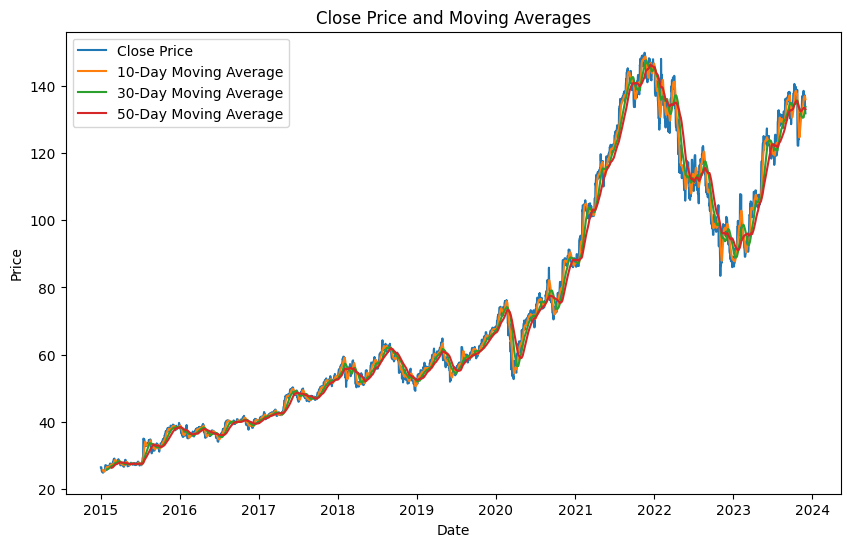

In [21]:
# Moving Average :  By using moving averages of different lengths (e.g., 50-day, 100-day, 200-day),you can compare short-term trends 
# against long-term trends.Convergence or divergence of these averages can indicate potential market changes.
df_g['MA_10'] = df_g['Close'].rolling(window=10).mean() 
df_g['MA_30'] = df_g['Close'].rolling(window=30).mean() 
df_g['MA_50'] = df_g['Close'].rolling(window=50).mean()  

plt.figure(figsize=(10, 6))
plt.plot(df_g['Close'], label='Close Price')
plt.plot(df_g['MA_10'], label='10-Day Moving Average')
plt.plot(df_g['MA_30'], label='30-Day Moving Average')
plt.plot(df_g['MA_50'], label='50-Day Moving Average')
plt.title('Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# MODELS

## ML Models - LR, LASSO, RIDGE, MLPREGRESSOR

In [22]:
# We are using Adjusted Close as our predicted vaalues, becuase it gives us the complete picture of the stocks's value, and help
# in understanding the stock chnage over the long preiod, where as the close, open, values talks for that day.
df_g = df_g.drop(['MA_10','MA_30','MA_50'],axis=1)
ac = df_g[['Adj Close']]

In [42]:
def box_compare(model_results, model_names):
  sns.set(rc={'figure.figsize':(15, 9)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

Linear: 0.636663, (0.279622)
Lasso: 0.414991, (0.736533)
Ridge: 0.636323, (0.280351)
ElasticNet: 0.444782, (0.6683)
KNN: -2.577997, (3.906179)
DecisionTree: -2.741696, (4.074045)
SVR: -12.204993, (14.428213)
AdaBoost: -2.887824, (4.103816)
GradientBoost: -2.651964, (4.000651)
RandomForest: -2.662345, (4.080445)
ExtraTrees: -2.708777, (4.093633)
BaggingRegressor: -2.671169, (4.110847)
XGBRegressor: -2.582006, (4.122961)
MLPRegressor: 0.636663, (0.279621)


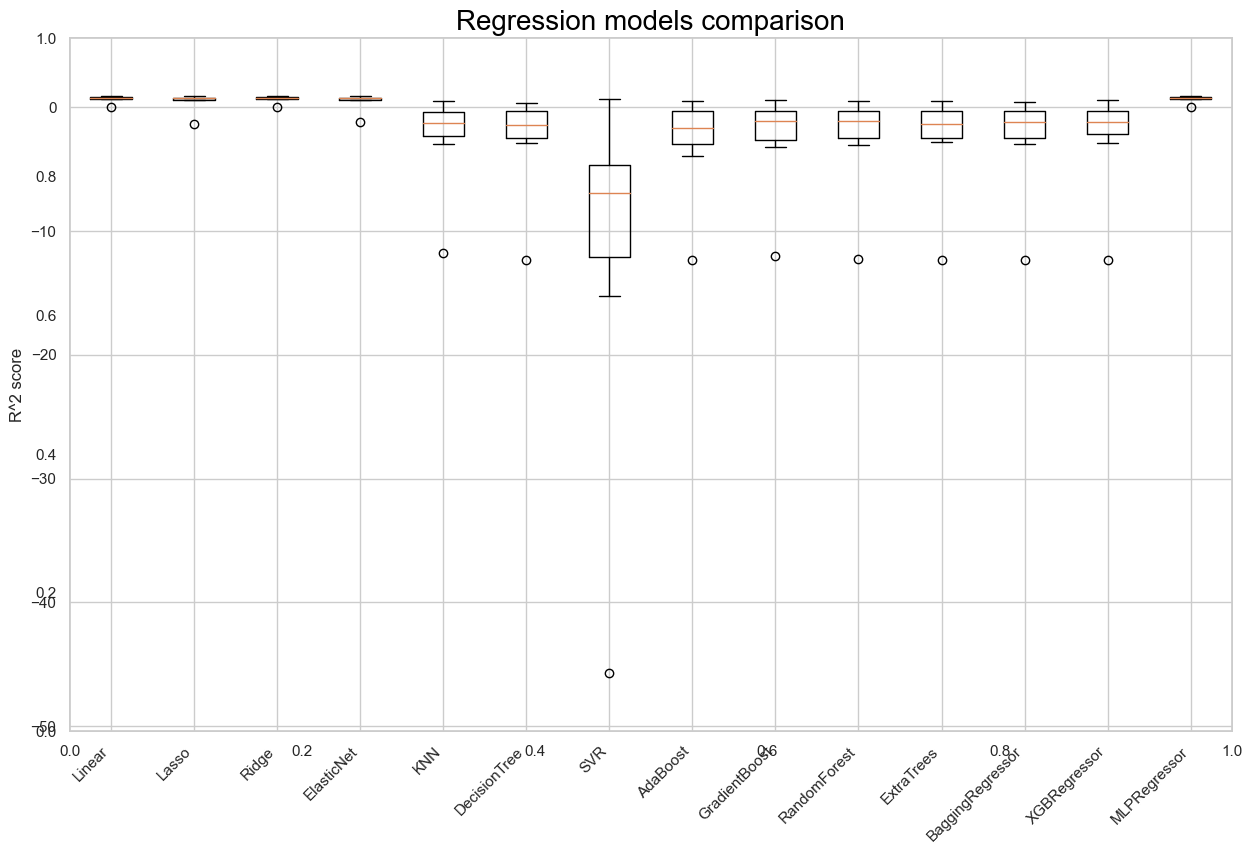

In [43]:
def models_value(data):
    forecast_out = 7
    data['Prediction'] = data[['Adj Close']].shift(-forecast_out)
    X = np.array(data.drop(['Prediction'], axis=1))
    X = X[:-forecast_out]
    y = np.array(data['Prediction'])
    y = y[:-forecast_out]  
    train_size = int(X.shape[0]*0.7)
    X_train = X[0:train_size]
    y_train = y[0:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:] 
    models = {}
    models["Linear"] = LinearRegression()
    models["Lasso"] = Lasso()
    models["Ridge"] = Ridge()
    models["ElasticNet"] = ElasticNet()
    models["KNN"] = KNeighborsRegressor()
    models["DecisionTree"] = DecisionTreeRegressor()
    models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
    models["AdaBoost"] = AdaBoostRegressor()
    models["GradientBoost"] = GradientBoostingRegressor()
    models["RandomForest"] = RandomForestRegressor()
    models["ExtraTrees"]= ExtraTreesRegressor()
    models["BaggingRegressor"] = BaggingRegressor()
    models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
    models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')
    model_results = []  
    model_names   = []
    for model_name in models:
        model = models[model_name]
        tscv = TimeSeriesSplit(n_splits=7)
        
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
        model_results.append(cv_results)
        model_names.append(model_name)
        print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))

    return model_results,model_names

model_results,model_names = models_value(ac)
box_compare(model_results,model_names)


In [23]:
def LR(data,forecast_out):
    forecast_out = 7
    data['Prediction'] = data[['Adj Close']].shift(-forecast_out)
    X = np.array(data.drop(['Prediction'], axis=1))
    X = X[:-forecast_out]
    y = np.array(data['Prediction'])
    y = y[:-forecast_out]  
    train_size = int(X.shape[0]*0.7)
    X_train = X[0:train_size]
    y_train = y[0:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:] 
    X_forecast = np.array(data.drop(['Prediction'],axis=1))[-forecast_out:]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    print('Coefficients: ', lr.coef_)
    print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
    print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))
    lr_prediction = lr.predict(X_forecast)
    train = data[:train_size]
    test = data[train_size:-forecast_out]
    test['Predictions'] = predictions
    fore = data[-forecast_out:]
    fore['Predictions'] = lr_prediction
    return train,test,fore

In [29]:
def Lass(data,forecast_out):
    forecast_out = 7
    data['Prediction'] = data[['Adj Close']].shift(-forecast_out)
    X = np.array(data.drop(['Prediction'], axis=1))
    X = X[:-forecast_out]
    y = np.array(data['Prediction'])
    y = y[:-forecast_out]  
    train_size = int(X.shape[0]*0.7)
    X_train = X[0:train_size]
    y_train = y[0:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:] 
    X_forecast = np.array(data.drop(['Prediction'],axis=1))[-forecast_out:]
    lasso = Lasso()
    lasso.fit(X_train, y_train)
    predictions = lasso.predict(X_test)
    print('Coefficients: ', lasso.coef_)
    print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
    print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))
    ls_prediction = lasso.predict(X_forecast)
    train = data[:train_size]
    test = data[train_size:-forecast_out]
    test['Predictions'] = predictions
    fore = data[-forecast_out:]
    fore['Predictions'] = ls_prediction
    return train,test,fore

In [33]:
def Rid(data,forecast_out):
    forecast_out = 7
    data['Prediction'] = data[['Adj Close']].shift(-forecast_out)
    X = np.array(data.drop(['Prediction'], axis=1))
    X = X[:-forecast_out]
    y = np.array(data['Prediction'])
    y = y[:-forecast_out]  
    train_size = int(X.shape[0]*0.7)
    X_train = X[0:train_size]
    y_train = y[0:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:] 
    X_forecast = np.array(data.drop(['Prediction'],axis=1))[-forecast_out:]
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    predictions = ridge.predict(X_test)
    print('Coefficients: ', ridge.coef_)
    print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
    print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))
    ridge_prediction = ridge.predict(X_forecast)
    train = data[:train_size]
    test = data[train_size:-forecast_out]
    test['Predictions'] = predictions
    fore = data[-forecast_out:]
    fore['Predictions'] = ridge_prediction
    return train,test,fore

In [44]:
def mlp(data,forecast_out):
    forecast_out = 7
    data['Prediction'] = data[['Adj Close']].shift(-forecast_out)
    X = np.array(data.drop(['Prediction'], axis=1))
    X = X[:-forecast_out]
    y = np.array(data['Prediction'])
    y = y[:-forecast_out]  
    train_size = int(X.shape[0]*0.7)
    X_train = X[0:train_size]
    y_train = y[0:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:] 
    X_forecast = np.array(data.drop(['Prediction'],axis=1))[-forecast_out:]
    mlp = MLPRegressor(solver = 'lbfgs')
    mlp.fit(X_train, y_train)
    predictions = mlp.predict(X_test)
    print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
    print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))
    ridge_prediction = mlp.predict(X_forecast)
    train = data[:train_size]
    test = data[train_size:-forecast_out]
    test['Predictions'] = predictions
    fore = data[-forecast_out:]
    fore['Predictions'] = ridge_prediction
    return train,test,fore

## NN

In [131]:
def nn_data_creation(data):
    adj_values = data[['Adj Close']].values
    needed = int(len(adj_values)*0.8)
    train = adj_values[0:needed, :]
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = scaler.fit_transform(train)
    X_train = []
    y_train = []
    for i in range(7, len(train_scaled)):
        X_train.append(train_scaled[i-7:i, 0])
        y_train.append(train_scaled[i:i+1, 0]) 
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    test = data[['Adj Close']][needed:]
    inputs = data[['Adj Close']][len(adj_values) - len(test) - 7:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    
    X_test = []
    y_test = adj_values[needed:, :]
    for i in range(7,inputs.shape[0]):
        X_test.append(inputs[i-7:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train,y_train,X_test,y_test,scaler

In [132]:
def lstm(X_train,y_train):
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, epochs = 200, batch_size = 64,verbose = 0)
    return model


In [133]:
from keras.layers import SimpleRNN
def rnn_model(X_train,y_train):
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1],1)))  
    model.add(Dropout(0.2))
    model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1],1))) 
    model.add(Dropout(0.2)) 
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=0)
    return model

In [134]:
from keras.layers import GRU
def gru_model(X_train,y_train):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train,y_train,epochs=200,batch_size=64,verbose = 0)
    return model

In [135]:
def model_out(data,name):
    X_train,y_train,X_test,y_test,scaler = nn_data_creation(data)
    if name == 'lstm':
        model = lstm(X_train,y_train)
    elif name == 'rnn':
        model = rnn_model(X_train,y_train)
    elif name == "gru":
        model = gru_model(X_train,y_train)
    predictions = model.predict(X_test,verbose=0)
    predictions = scaler.inverse_transform(predictions)
    #rmse = np.sqrt(np.mean(predictions - y_test)**2)  
    print('RMSE: {}'.format(round(mean_squared_error(predictions ,y_test, squared=False), 3)))
    print('R^2 score: {}'.format(round(r2_score(predictions, y_test), 3)))
    needed = int(len(data)*0.8)
    train = data[:needed]
    test = data[needed:]
    test['Predictions'] = predictions
    plt.figure(figsize=(20,10))
    sns.set_style("whitegrid")
    plt.plot(train['Adj Close'], label='Training')
    plt.plot(test['Adj Close'], label='Actual')
    plt.plot(test['Predictions'], label='Predicted')
    plt.title("AZN Close Price - "+name, color = 'black', fontsize = 20)
    plt.xlabel('Year', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price', color = 'black', fontsize = 15)
    plt.legend()

## ARIMA

In [7]:
def arima(data):
    y = data['Adj Close']
    auto_model = auto_arima(y, start_p=0, start_q=0,
                            test='adf',
                            max_p=5, max_q=5,
                            m=1, d=None, seasonal=False,
                            start_P=0, D=0, trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
    train = y[:-7]
    test = y[-7:]
    model = ARIMA(train, order=auto_model.order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=7)
    forecast.index = test.index
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y.index, y=y, mode='lines', name='Actual Adj Close - All Data'))
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast, mode='lines', name='Predicted Adj Close - 7 Days'))
    fig.update_layout(title='ARIMA Model: Actual vs Predicted Adj Close Values',
                    xaxis_title='Date',
                    yaxis_title='Adj Close Price',
                    template='plotly_dark')
    fig.show()
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'RMSE: {rmse}')

## MODEL CALLING

Coefficients:  [1.00205356]
RMSE: 4.947
R^2 score: 0.914


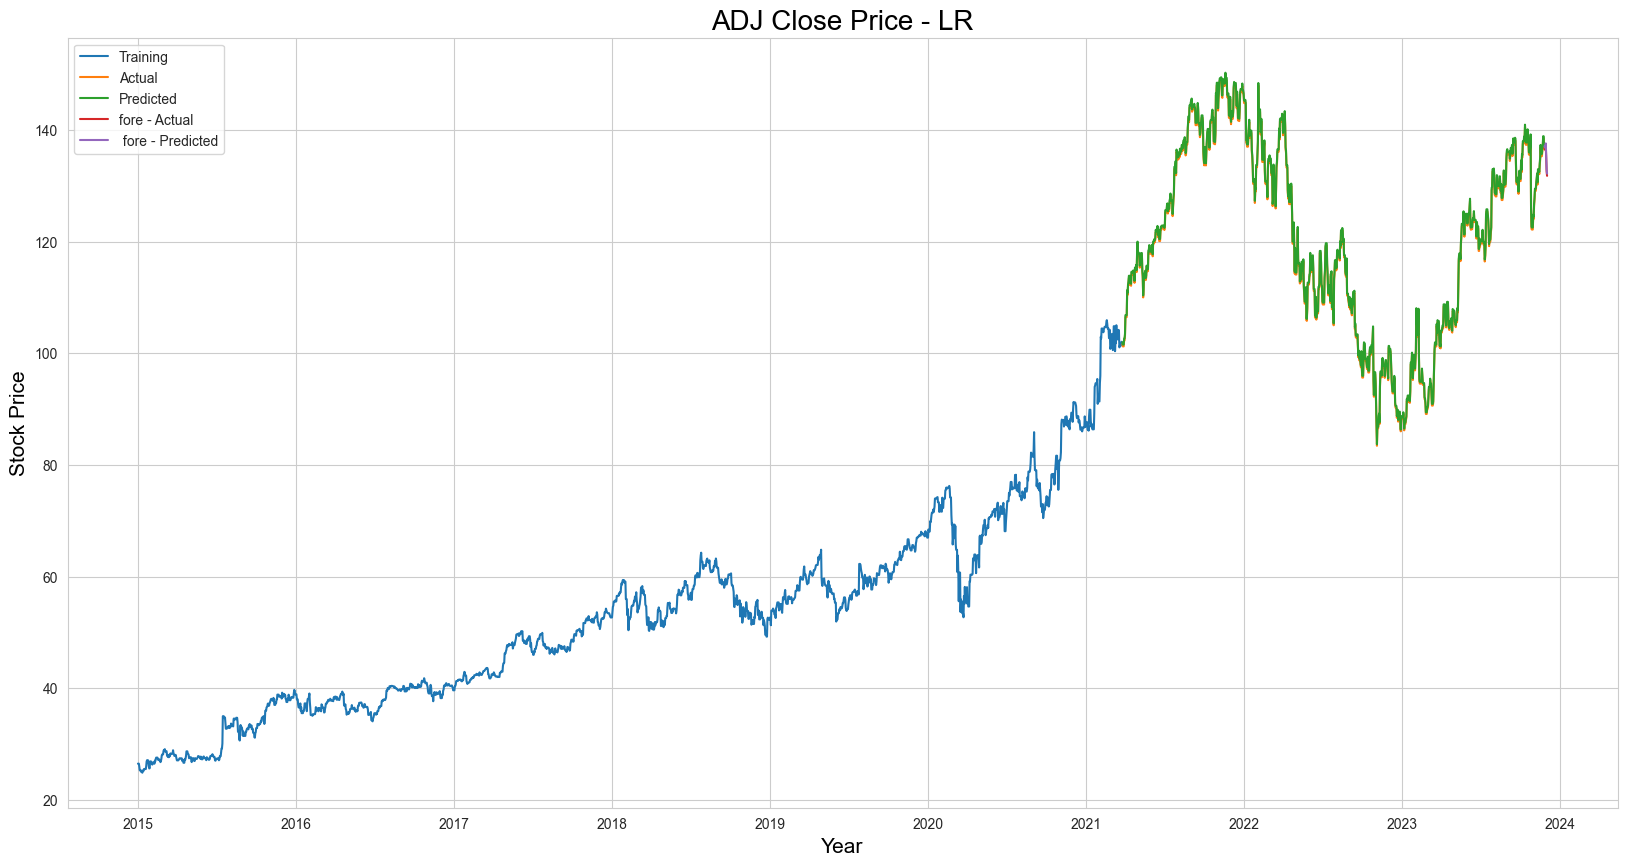

In [28]:
# Google LR
train , test, fore = LR(ac,7)
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.plot(fore['Adj Close'], label='fore - Actual')
plt.plot(fore['Predictions'], label=' fore - Predicted')
plt.title("ADJ Close Price - LR", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend()

Coefficients:  [0.99867894]
RMSE: 4.937
R^2 score: 0.914


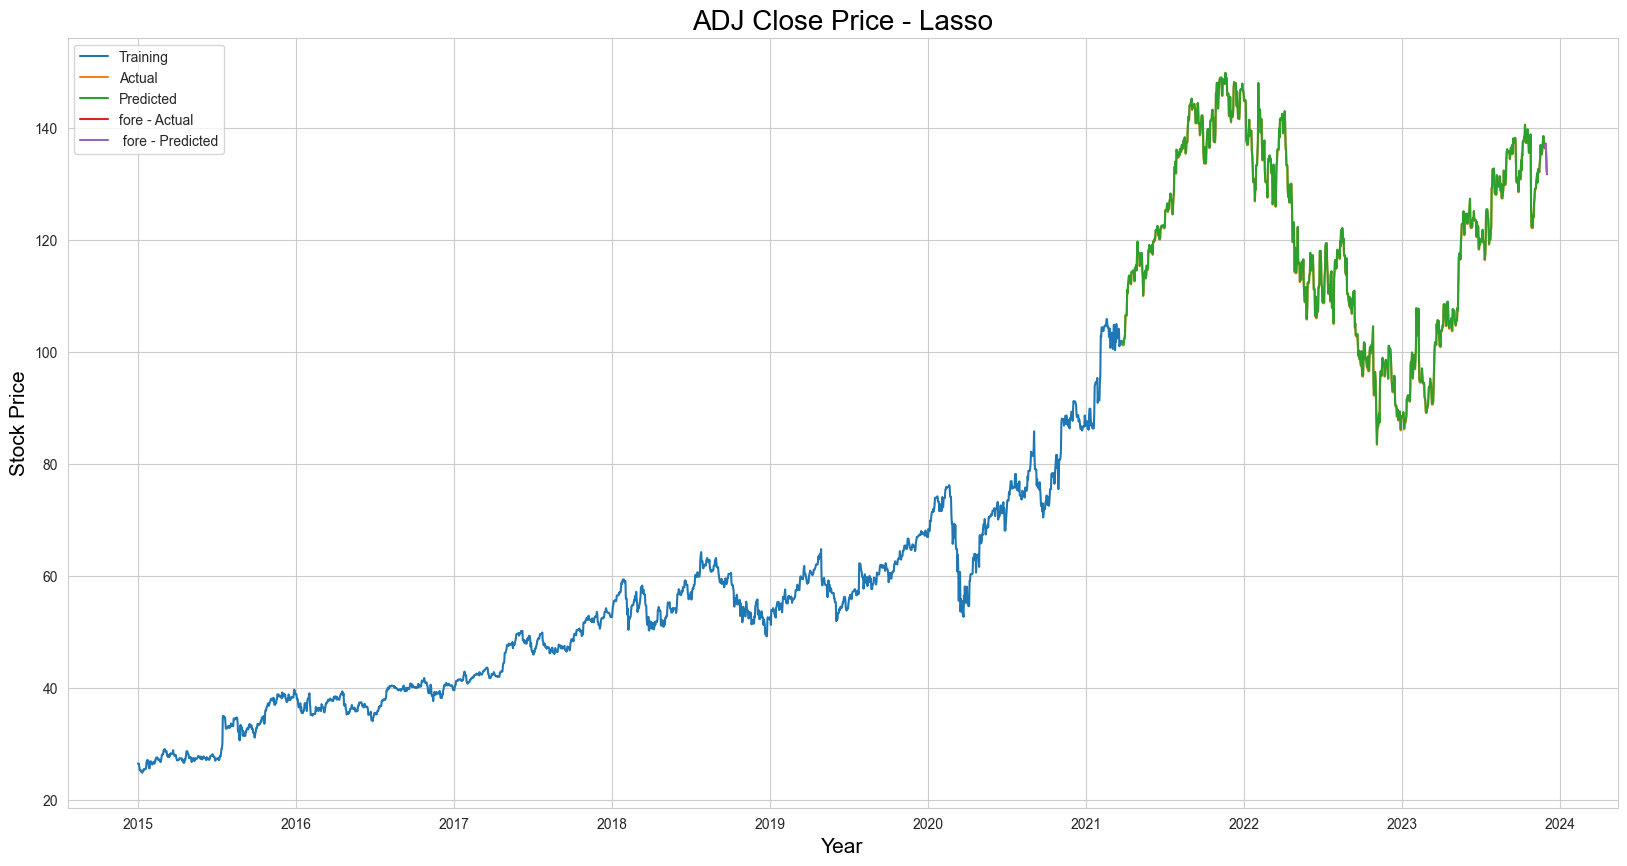

In [32]:
# Google Lasso
train , test, fore = Lass(ac,7)
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.plot(fore['Adj Close'], label='fore - Actual')
plt.plot(fore['Predictions'], label=' fore - Predicted')
plt.title("ADJ Close Price - Lasso", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend()

Coefficients:  [1.00205207]
RMSE: 4.947
R^2 score: 0.914


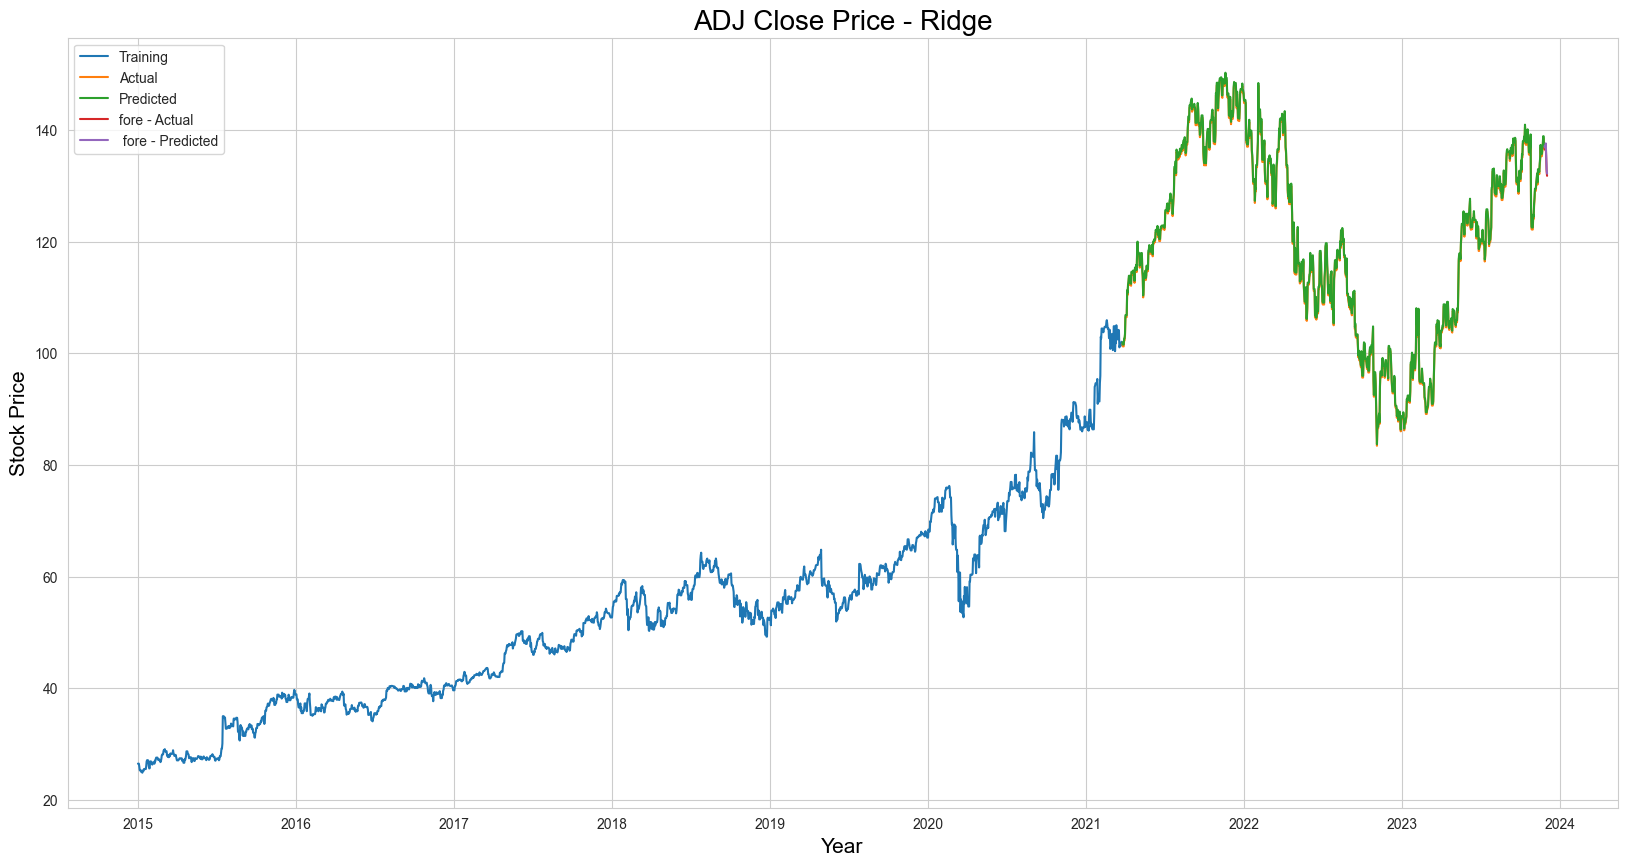

In [35]:
# Google Ridge
train , test, fore = Rid(ac,7)
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.plot(fore['Adj Close'], label='fore - Actual')
plt.plot(fore['Predictions'], label=' fore - Predicted')
plt.title("ADJ Close Price - Ridge", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend()

RMSE: 4.947
R^2 score: 0.914


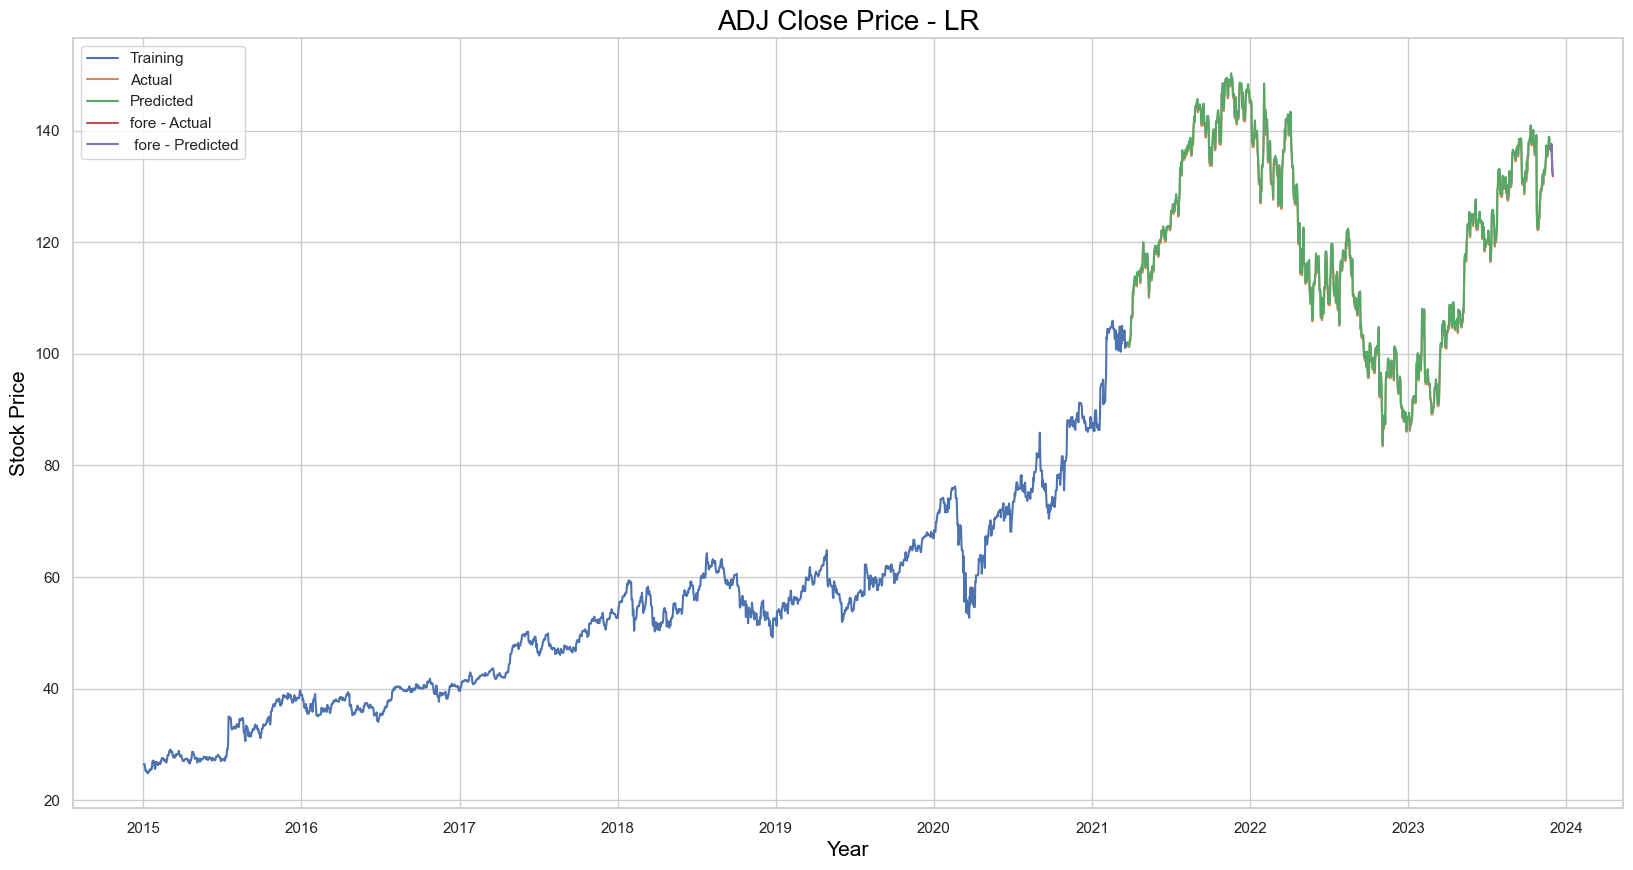

In [45]:
# Google MLP
train , test, fore = mlp(ac,7)
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.plot(fore['Adj Close'], label='fore - Actual')
plt.plot(fore['Predictions'], label=' fore - Predicted')
plt.title("ADJ Close Price - LR", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend()

RMSE: 3.667
R^2 score: 0.944


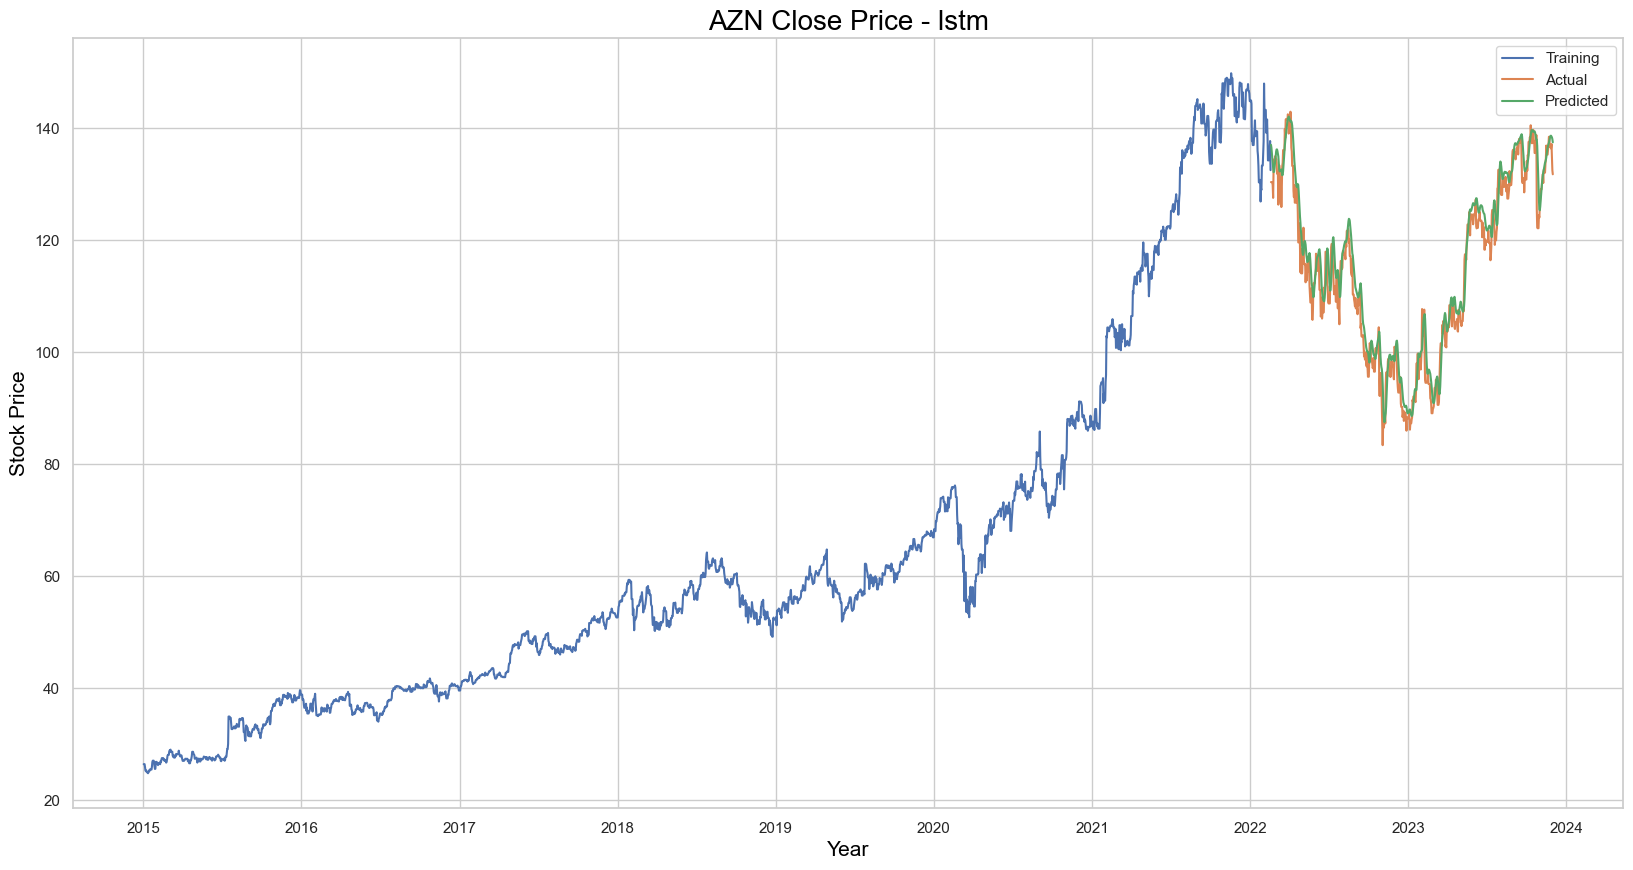

In [120]:
model_out(ac,name='lstm')

RMSE: 3.585
R^2 score: 0.949


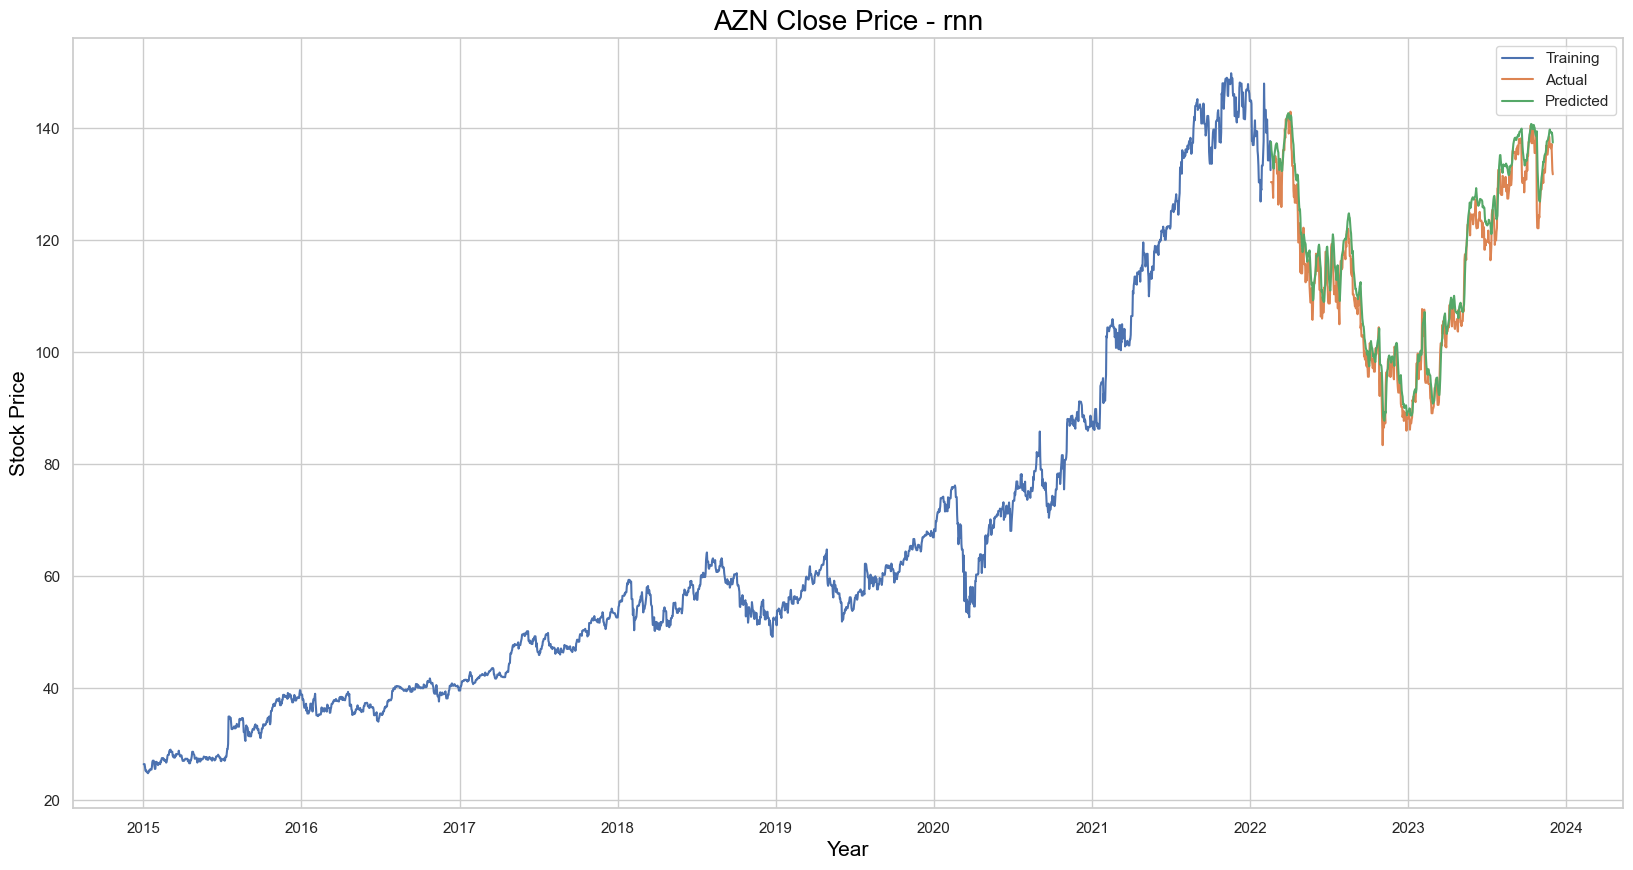

In [126]:
model_out(ac,name='rnn')

RMSE: 2.618
R^2 score: 0.971


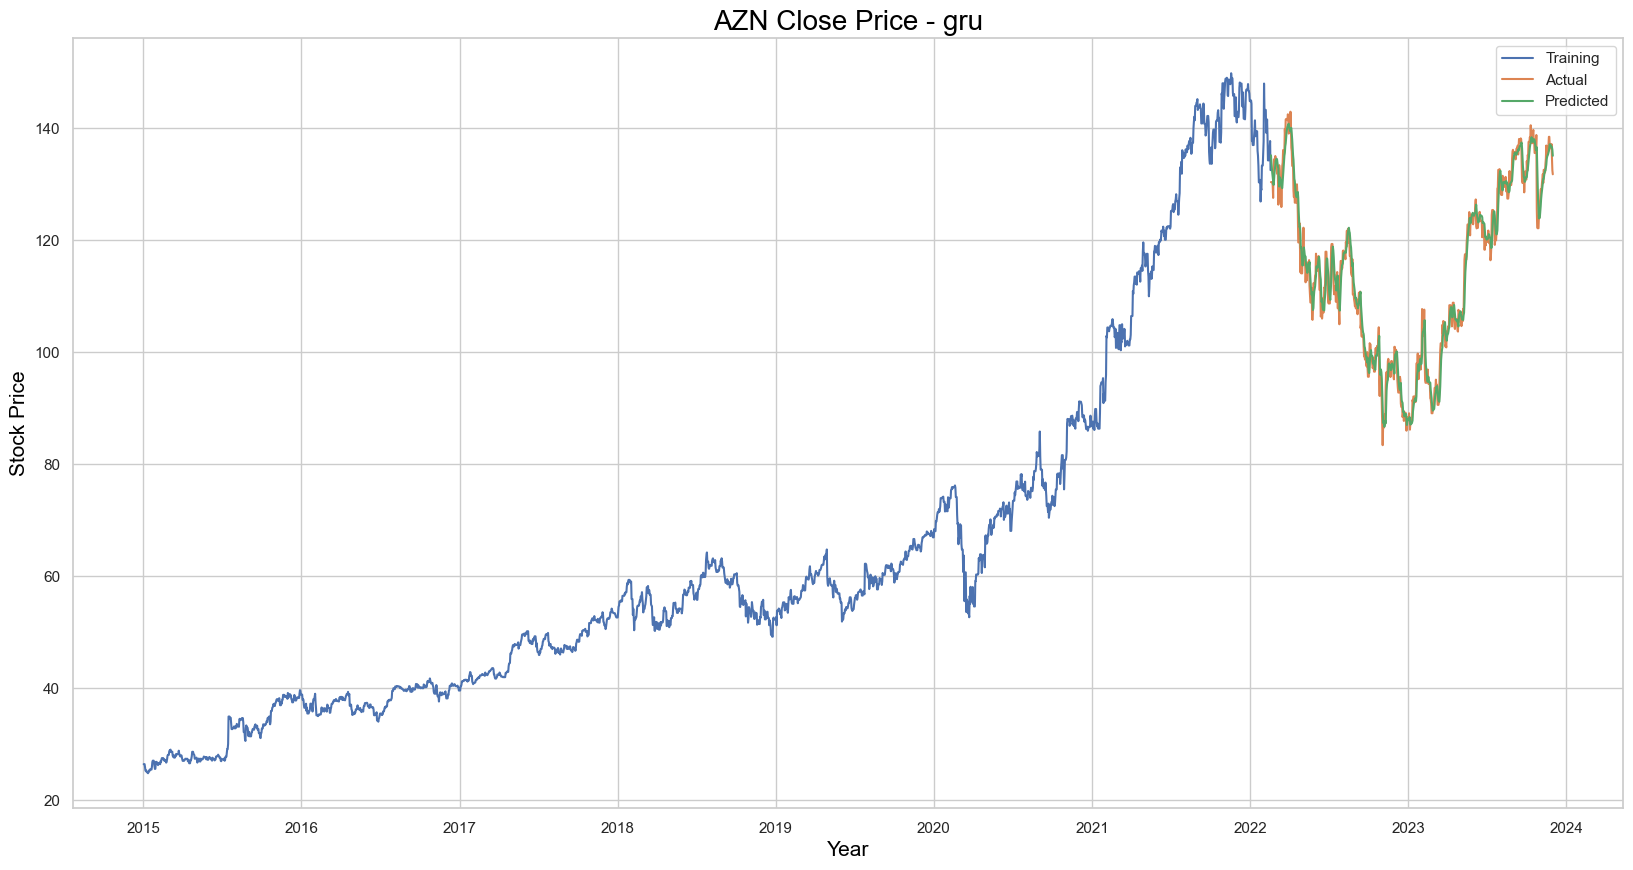

In [130]:
model_out(ac,name='gru')

In [8]:
arima(df_g)

RMSE: 2.363330936520343


## Sentiment+MOdel